In [1]:
from dendrocat import RadioSource
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import sys
import importlib
from astropy.wcs import WCS
from scipy import interpolate
import pandas as pd
import sympy as syp
from astropy import units as u
import radio_beam
from astropy.table import Table
from radio_beam import Beam
from astropy import coordinates
from astropy import wcs
from astropy.nddata.utils import Cutout2D
from dendrocat.aperture import Ellipse
from regions import Regions, PixCoord
from astropy import stats
from itertools import chain
from radio_beam import Beams
from astropy.convolution import convolve
import seaborn as sns
import Paths.Paths as paths
Path = paths.filepaths()



In [2]:
def cen_freq(center, delta ,alpha=2):
    start = center-delta/2 ; end = center+delta/2
    freqarr = np.logspace(np.log10(start),np.log10(end),20)
    dfreq = freqarr[1:]-freqarr[:-1]
    dfreq = np.append(dfreq,[dfreq[-1]])
    
    integral_up = np.sum(freqarr**(alpha+1)*dfreq)
    integral_down = np.sum(freqarr**(alpha)*dfreq)
    return integral_up/integral_down

def get_noise(image, wcsNB, noiseregion):
    container = []
    for reg in noiseregion:
        pix_reg = reg.to_pixel(wcsNB)
        noisemask = pix_reg.to_mask()
        noiseim = noisemask.cutout(image)
        container.append(noiseim.flatten())
    noiseim = list(chain.from_iterable(container))
    std = stats.mad_std(noiseim,ignore_nan=True)

    return std

def convolveb3b6(b3data, b6data, outdir, label):
    fitsdata_b6 = fits.open(b6data)
    image_b6 = fitsdata_b6[0].data[0][0]
    fitsdata_b3 = fits.open(b3data)
    image_b3 = fitsdata_b3[0].data[0][0]
    
    hdrNB6 = fits.getheader(b6data)  
    hdrNB3 = fits.getheader(b3data)  
    wcsNB6 = WCS(hdrNB6,naxis=2)
    wcsNB3 = WCS(hdrNB3,naxis=2)

    my_beamNB3 = Beam.from_fits_header(hdrNB3)
    my_beamNB6 = Beam.from_fits_header(hdrNB6)

    scaleNB6 = wcsNB6.proj_plane_pixel_scales()[0]
    scaleNB3 = wcsNB3.proj_plane_pixel_scales()[0]

    beamsN =  Beams(beams=[my_beamNB3,my_beamNB6])

    common_beam = beamsN.common_beam()
    print(common_beam.major)
    
    area_rat_B3 = (common_beam.sr/my_beamNB3.sr).value

    if area_rat_B3!=1:
        print('convolution', b3data)
        kernelB3 = common_beam.deconvolve(my_beamNB3).as_kernel(scaleNB3)
        conv_B3 = convolve(image_b3, kernelB3,preserve_nan=True)
        conv_B3 = conv_B3 * area_rat_B3
        if common_beam.major.unit=='arcsec':
            hdrNB3['BMAJ'] = common_beam.major.value/3600
            hdrNB3['BMIN'] = common_beam.minor.value/3600
            hdrNB3['BPA'] = common_beam.pa.value
        else:
            hdrNB3['BMAJ'] = common_beam.major.value
            hdrNB3['BMIN'] = common_beam.minor.value
            hdrNB3['BPA'] = common_beam.pa.value
        #fits.writeto(outdir+'/%s_B3_conv.fits'%label, conv_B3, hdrNB3, overwrite = True)
    
    area_rat_B6 = (common_beam.sr/my_beamNB6.sr).value
    if area_rat_B6 != 1:
        print('convolution', b6data)
        kernelB6 = common_beam.deconvolve(my_beamNB6).as_kernel(scaleNB6)
        conv_B6 = convolve(image_b6, kernelB6,preserve_nan=True)  
        conv_B6 = conv_B6 * area_rat_B6
        if common_beam.major.unit=='arcsec':
            hdrNB6['BMAJ'] = common_beam.major.value/3600
            hdrNB6['BMIN'] = common_beam.minor.value/3600
            hdrNB6['BPA'] = common_beam.pa.value
        else:
            hdrNB3['BMAJ'] = common_beam.major.value
            hdrNB3['BMIN'] = common_beam.minor.value
            hdrNB3['BPA'] = common_beam.pa.value
        #fits.writeto(outdir+'/%s_B6_conv.fits'%label, conv_B6, hdrNB6, overwrite = True)
    return conv_B6


def measure_alpha(b3data, b6data, b3noisereg, b6noisereg, table, b6image=None, b6noise=None, save=True,sigma=3):
    t = Table.read(table)
    peakx_b6 = t['b6_xsky']
    peaky_b6 = t['b6_ysky']
    b6outside = np.where(t['is_overlap']==False)[0]
    peakxy_b6 = np.vstack((peakx_b6,peaky_b6)).T
    
    b6unmatched = np.where(peakx_b6<0)[0]

    peakx_b3 = t['b3_xsky']
    peaky_b3 = t['b3_ysky']
    peakxy_b3 = np.vstack((peakx_b3,peaky_b3)).T
    b3outside = np.where(t['is_overlap']==False)[0]

    b3unmatched = np.where(peakx_b3<0)[0]

    print('unmatched',len(b6unmatched),len(b3unmatched))
    fitsdata_b3 = fits.open(b3data)
    imageb3 = fitsdata_b3[0].data
    if len(imageb3.shape)!=2:
        imageb3 = imageb3[0][0]
    
    fitsdata_b6 = fits.open(b6data)
    imageb6 = fitsdata_b6[0].data
    if len(imageb6.shape)!=2:
        imageb6 = imageb6[0][0]
    if b6image is not None:
        imageb6 = b6image
    hdrNB6 = fits.getheader(b6data)  
    hdrNB3 = fits.getheader(b3data)  
    wcsNB3 = WCS(hdrNB3,naxis=2)
    wcsNB6 = WCS(hdrNB6,naxis=2)
    
    b3noise = get_noise(imageb3, wcsNB3, b3noisereg)
    
    if b6noise is None:
        b6noise = get_noise(imageb6, wcsNB6, b6noisereg)
    print('noise',b3noise,b6noise)
    


    scaleNB3 = wcsNB3.proj_plane_pixel_scales()[0]
    scaleNB6 = wcsNB6.proj_plane_pixel_scales()[0]

    scaleNB3_sr = (scaleNB3 * np.pi/180)**2
    scaleNB6_sr = (scaleNB6 * np.pi/180)**2


    num_source = len(peakxy_b6)
    
    peakxy_b6_pix = wcsNB6.wcs_world2pix(peakxy_b6,0)
    peakxy_b3_pix = wcsNB3.wcs_world2pix(peakxy_b3,0)
    
    B6flux = [imageb6[int(xypix[1]),int(xypix[0])] if xypix[1]<imageb6.shape[0] and xypix[1]>0 else -1 for xypix in peakxy_b6_pix]
    B3flux = [imageb3[int(xypix[1]),int(xypix[0])] if xypix[1]<imageb3.shape[0] and xypix[1]>0 else -1 for xypix in peakxy_b3_pix]

    B6flux = np.array(B6flux)
    B3flux = np.array(B3flux)
    print(b6unmatched)
    B6flux[b6unmatched] = sigma*b6noise
    B3flux[b3unmatched] = sigma*b3noise

    
    freqb3 = cen_freq(hdrNB3['CRVAL3'],hdrNB3['CDELT4'])
    freqb6 = cen_freq(hdrNB6['CRVAL4'],hdrNB6['CDELT4'])
    print(freqb3, freqb6)
    alpha = np.log10(B3flux/B6flux)/np.log10(freqb3/freqb6)
    alphaerr = np.sqrt((b3noise/B3flux)**2+(b6noise/B6flux)**2)/B3flux*B6flux/np.log(freqb3/freqb6)
    
    alpha[b3outside] = -999
    alpha[b6outside] = -999
    print(alpha)
    if save:
        t['flux_peak_b3'] = B3flux
        t['flux_peak_b6'] = B6flux
        t['alpha'] = alpha
        t['alphaerr'] = alphaerr

        t.write(table,format='fits',overwrite=True)

    
    return alpha, alphaerr, B3flux, B6flux, b3noise, b6noise

read_w51e_b3_noise = Regions.read(Path.w51e_b3_noise_region,format='ds9')
read_w51e_b6_noise = Regions.read(Path.w51e_b6_noise_region,format='ds9')
read_w51n_b3_noise = Regions.read(Path.w51n_b3_noise_region,format='ds9')
read_w51n_b6_noise = Regions.read(Path.w51n_b6_noise_region,format='ds9')



In [3]:
#b6image = convolveb3b6(w51e_b3_tt0,w51e_b6_calibrated_pbcor,'/orange/adamginsburg/w51/TaehwaYoo/convolved_new/','w51e_new_nocorr_in_area')

fitsdata_b6 = fits.open(Path.w51e_b6_conv)
imageb6 = fitsdata_b6[0].data
if len(imageb6.shape)!=2:
    imageb6 = imageb6[0][0]
alpha_w51e, alphaerr_w51e, b3flux, b6flux, b3noise, b6noise = measure_alpha(Path.w51e_b3_tt0, Path.w51e_b6_conv,read_w51e_b3_noise,read_w51e_b6_noise, Path.w51e_dendro_matched_catalog,
                                                                            b6noise =0.00012361802520203196 )



unmatched 23 33
noise 2.0344283073177807e-05 0.00012361802520203196
[ 72  73  74  75  76  77  78  79  80  81  82 116 117 118 119 120 121 122
 123 124 125 126 127]
92982346121.91989 226691598706.70853
[ 2.96625047e+00  2.34316242e+00  2.45506891e+00  3.26472797e+00
  2.83448206e+00  2.51378980e+00  2.50396449e+00  7.08080930e-01
  2.18696003e+00  2.30766893e+00  2.27147317e+00  2.70056116e+00
  1.87316470e+00  2.20489432e+00  2.82170333e+00  2.37793999e+00
  2.67892596e+00  2.25207420e+00  3.26727790e+00  2.33118975e+00
  2.09986950e+00  2.70863872e+00  2.76226671e+00  1.97934017e+00
  2.40317847e+00  1.87257230e+00  2.97391542e+00  2.52749973e+00
  1.88155608e+00  1.08795240e+00  2.99619544e+00  2.52075538e+00
  2.83578788e+00  1.38731761e+00  2.02129117e+00  2.41279821e+00
  2.82331076e+00  1.89571180e+00  2.82912284e+00  2.66683705e+00
  1.67876268e+00 -1.78542986e-01  2.22218858e+00  2.30864067e+00
  1.88464555e+00  2.58238483e+00  2.83835608e+00  2.65281318e+00
  2.02643554e+00  2.

In [4]:
#b6image = convolveb3b6(w51n_b3_tt0,w51n_b6_calibrated_pbcor,'/orange/adamginsburg/w51/TaehwaYoo/convolved_new/','w51n_new_nocorr_in_area')#

#alpha_w51n,alphaerr_w51n ,b3flux, b6flux, b3noise, b6noise = measure_alpha(w51n_b3_tt0, w51n_b6_conv,read_w51n_b3_noise,read_w51n_b6_noise, w51n_matched_catalog,b6image=b6image)
fitsdata_b6 = fits.open(Path.w51n_b6_conv)
imageb6 = fitsdata_b6[0].data
if len(imageb6.shape)!=2:
    imageb6 = imageb6[0][0]
alpha_w51n, alphaerr_w51n, b3flux, b6flux, b3noise, b6noise = measure_alpha(Path.w51n_b3_tt0, Path.w51n_b6_conv,read_w51n_b3_noise,read_w51n_b6_noise, Path.w51n_dendro_matched_catalog,
                                                                            b6noise =8.95845803518789e-05 )



unmatched 49 4
noise 2.046915070510816e-05 8.95845803518789e-05
[21 22 23 24 25 26 27 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73]
92982344741.79 226691594459.07156
[ 2.96313723e+00  1.90276240e+00  7.23525878e-01  2.17842132e-01
  2.19329171e+00  2.33482207e+00  2.32938579e+00  2.38539210e+00
  2.69392483e+00  1.84048725e+00  1.83067782e+00  2.20923372e+00
  2.77026712e+00  1.77166532e+00  2.17477925e+00  2.78506596e+00
  1.44498156e+00  1.29479478e+00  1.75755090e+00  1.91018794e+00
  2.12094486e+00  8.19577899e-01  8.25692855e-01 -1.13658538e+00
 -1.74389671e+00  3.78567355e-01  2.18283623e-01 -1.12080381e-01
  2.87910505e+00  5.39165669e+00  5.40917092e+00  5.78441027e+00
 -9.99000000e+02 -9.99000000e+02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02 -9.

      alphaerr     
-------------------
 1.2066185113331902
 0.3188227698992003
 0.6800431237593367
 1.6654811538342746
0.31375004700100473
 0.8769643929080694
  1.017563611515281
0.13070461582211224
0.11577848916201172
0.19054845959477537
                ...
0.35705563984425365
0.42768474489891994
 0.5446716814912035
 0.3746209473434099
 0.5467838446787956
0.44368256917926885
 0.9444504507083115
 0.5165602123050286
0.34690579451616965
 0.4799343437011882
 0.7051447384091275
Length = 128 rows
23 42 7
10 2 9


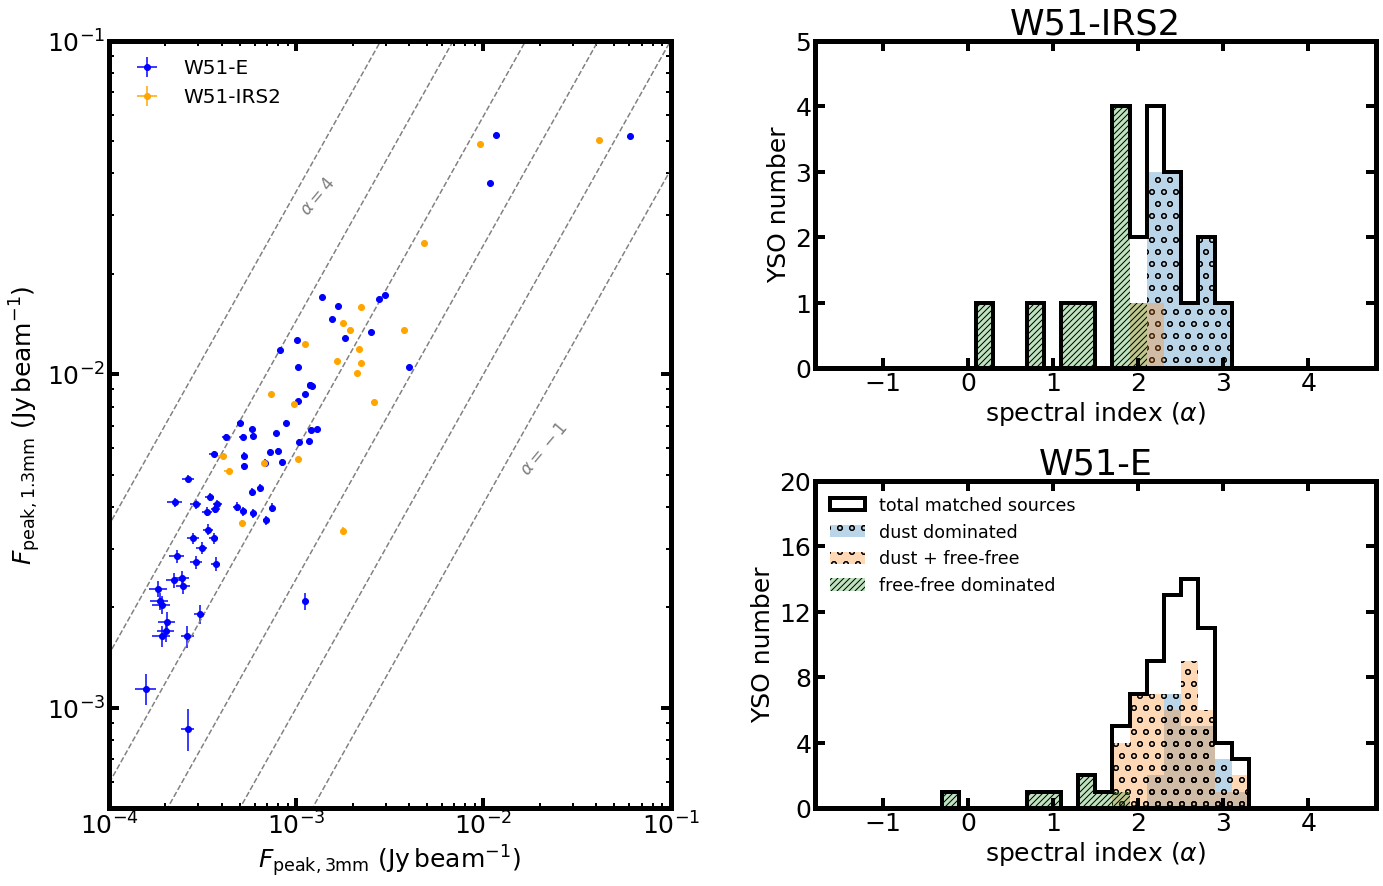

In [5]:
import matplotlib as mpl
import astropy.constants as c
from scipy.interpolate import CubicSpline

def get_bb_intensity(freq, surf_den,T_thin):
    
    kappa_ = kappa(freq)
    
    I_nu =  2 * c.h * freq**3 / (c.c**2) * (np.e**(c.h*freq/(c.k_B*T_thin)) - 1)**(-1) * (1 - np.e**((-kappa_ * surf_den).to(u.dimensionless_unscaled))) /u.sr
    
    return I_nu.to(u.Jy/u.sr)
def kappa(nu, nu0=271.1*u.GHz, kappa0=0.0114*u.cm**2*u.g**-1, beta=1.75):
    """
    Compute the opacity $\kappa$ given a reference frequency (or wavelength)
    and a power law governing the opacity as a fuction of frequency:
    $$ \kappa = \kappa_0 \left(\\frac{\\nu}{\\nu_0}\\right)^{\\beta} $$
    The default kappa=0.0114 at 271.1 GHz comes from extrapolating the
    Ossenkopf & Henning 1994 opacities for the thin-ice-mantle, 10^6 year model
    anchored at 1.0 mm with an assumed beta of 1.75.
    Parameters
    ----------
    nu: astropy.Quantity [u.spectral() equivalent]
        The frequency at which to evaluate kappa
    nu0: astropy.Quantity [u.spectral() equivalent]
        The reference frequency at which $\kappa$ is defined
    kappa0: astropy.Quantity [cm^2/g]
        The dust opacity per gram of H2 along the line of sight.  Because of
        the H2 conversion, this factor implicitly includes a dust to gas ratio
        (usually assumed 100)
    beta: float
        The power-law index governing kappa as a function of nu
    """
    return (kappa0*(nu.to(u.GHz,u.spectral())/nu0.to(u.GHz,u.spectral()))**(beta)).to(u.cm**2/u.g)
plt.rcParams['axes.labelsize']=25
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25
plt.rcParams['axes.titlesize']=25
mpl.rcParams['axes.linewidth'] = 5
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 4
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 4
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 2
params = {"xtick.top": True, "ytick.right": True, "xtick.direction": "in", "ytick.direction": "in"}
plt.rcParams.update(params)
w51ecat = Table.read(Path.w51e_dendro_matched_catalog)
w51e_matched = np.where(w51ecat['is_matched'])[0]
w51ncat = Table.read(Path.w51n_dendro_matched_catalog)
w51n_matched = np.where(w51ncat['is_matched'])[0]
w51e_unmatched_b3 = np.where(w51ecat['b3_xsky']<0)[0]
w51e_unmatched_b6 = np.where(w51ecat['b6_xsky']<0)[0]
w51n_unmatched_b3 = np.where(w51ncat['b3_xsky']<0)[0]
w51n_unmatched_b6 = np.where(w51ncat['b6_xsky']<0)[0]

hdrNB6 = fits.getheader(Path.w51e_b6_conv)  
hdrNB3 = fits.getheader(Path.w51e_b3_tt0)  


my_beamNB3 = Beam.from_fits_header(hdrNB3)
my_beamNB6 = Beam.from_fits_header(hdrNB6)
    

alpha_w51e = w51ecat['alpha']
alpha_w51n = w51ncat['alpha']
alpha_w51e_err = np.abs(w51ecat['alphaerr'])
alpha_w51n_err = np.abs(w51ncat['alphaerr'])

b3peak_w51e = w51ecat['flux_peak_b3'] 
b6peak_w51e = w51ecat['flux_peak_b6'] 

b3peak_w51n = w51ncat['flux_peak_b3'] 
b6peak_w51n = w51ncat['flux_peak_b6'] 

b3noise_w51e = 2.065537678896079e-05 
b6noise_w51e = 0.00012361802520203196
b3noise_w51n = 2.220660593897177e-05
b6noise_w51n = 8.95845803518789e-05

groupa_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e-alpha_w51e_err>2))[0]
groupb1_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e>2)&(alpha_w51e-alpha_w51e_err<2))[0]
groupb2_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e<2)&(alpha_w51e+alpha_w51e_err>2))[0]
groupb_ind_w51e = np.append(groupb1_ind_w51e,groupb2_ind_w51e)
groupc_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e+alpha_w51e_err<2))[0]

grouparr = np.zeros(len(alpha_w51e))
grouparr[groupa_ind_w51e]=0
grouparr[groupb_ind_w51e]=1
grouparr[groupc_ind_w51e]=2

w51ecat['group']=grouparr

print(alpha_w51e_err)
groupa_ind_w51n = np.where((w51ncat['is_matched'])&(alpha_w51n-alpha_w51n_err>2))[0]
groupb1_ind_w51n = np.where((w51ncat['is_matched'])&(alpha_w51n>2)&(alpha_w51n-alpha_w51n_err<2))[0]
groupb2_ind_w51n = np.where((w51ncat['is_matched'])&(alpha_w51n<2)&(alpha_w51n+alpha_w51n_err>2))[0]
groupb_ind_w51n = np.append(groupb1_ind_w51n,groupb2_ind_w51n)
groupc_ind_w51n = np.where((w51ncat['is_matched'])&(alpha_w51n+alpha_w51n_err<2))[0]

grouparr = np.zeros(len(alpha_w51n))
grouparr[groupa_ind_w51n]=0
grouparr[groupb_ind_w51n]=1
grouparr[groupc_ind_w51n]=2

w51ncat['group']=grouparr


#alpha_w51n_err = np.sqrt((b3noise/b3flux)**2+(b6noise/b6flux)**2)/np.log(freqb3/freqb6)
#alpha_w51e_err =np.sqrt((b3noise/b3flux)**2+(b6noise/b6flux)**2)/np.log(freqb3/freqb6)
hdrNB6 = fits.getheader(Path.w51e_b6_cont)  
hdrNB3 = fits.getheader(Path.w51e_b3_tt0)  
b3freq = cen_freq(hdrNB3['CRVAL3'],hdrNB3['CDELT4'])
b6freq = cen_freq(hdrNB6['CRVAL4'],hdrNB6['CDELT4'])

fig = plt.figure(figsize=(20,13))
ax1 = fig.add_axes([0.1,0.08,0.39,0.82])
ax2 = fig.add_axes([0.59,0.08,0.39,0.35])
ax3 = fig.add_axes([0.59,0.55,0.39,0.35])

ax1.errorbar( b3peak_w51e[w51e_matched],b6peak_w51e[w51e_matched], xerr=b3noise_w51e, yerr=b6noise_w51e,fmt='o',c='b', label='W51-E')
ax1.errorbar( b3peak_w51n[w51n_matched],b6peak_w51n[w51n_matched], xerr=b3noise_w51n, yerr=b6noise_w51n,fmt='o',c='orange', label='W51-IRS2')
spectral_indices=[-1,0,1,2,3,4]
for si in spectral_indices:
    ax1.plot([1e-5,1e-1],10**(np.log10([1e-5,1e-1]) - np.log10(b3freq/b6freq) * si), c='grey',ls='dashed') 
ax1.text(1e-3,3e-2,r'$\alpha=4$',rotation=50,fontsize=17,c='gray')
ax1.text(1.5e-2,5e-3,r'$\alpha=-1$',rotation=50,fontsize=17,c='gray')    
ax1.set_ylabel(r'$F_{\rm peak, 1.3 mm}$ (${\rm Jy\,beam^{-1}}$)')
ax1.set_xlabel(r'$F_{\rm peak, 3 mm}$ (${\rm Jy\,beam^{-1}}$)')
ax1.set_xlim(1e-4,1e-1)
ax1.set_ylim(5e-4,1e-1)

ax1.set_xscale('log')
ax1.set_yscale('log')

avg_gas_mass = 2.8 * c.u # from https://dust-emissivity.readthedocs.io/en/latest/api/dust_emissivity.blackbody.modified_blackbody.html
H_2_den_min = 1e+21 / u.cm**2
H_2_den_max = 1e+27 / u.cm**2
den_min = ((H_2_den_min  * avg_gas_mass).to(u.kg/u.m**2)).value
den_max = ((H_2_den_max * avg_gas_mass).to(u.kg/u.m**2)).value
surf_den = np.geomspace(den_min, den_max, 1000) * u.kg / u.m**2
freq93 = 92.98 * u.GHz
freq225 = 226.69 * u.GHz
b3flux_20 = get_bb_intensity(freq93, surf_den, 20*u.K) * my_beamNB3.sr 
b6flux_20 = get_bb_intensity(freq225, surf_den, 20*u.K)* my_beamNB6.sr

b3flux_50 = get_bb_intensity(freq93, surf_den, 50*u.K)* my_beamNB3.sr
b6flux_50 = get_bb_intensity(freq225, surf_den, 50*u.K)* my_beamNB6.sr

b3flux_100 = get_bb_intensity(freq93, surf_den, 100*u.K)* my_beamNB3.sr
b6flux_100 = get_bb_intensity(freq225, surf_den, 100*u.K)* my_beamNB6.sr

b3flux_1 = get_bb_intensity(freq93, surf_den, 1*u.K) * my_beamNB3.sr
b6flux_1 = get_bb_intensity(freq225, surf_den, 1*u.K)* my_beamNB6.sr
b3flux_500 = get_bb_intensity(freq93, surf_den, 500*u.K)* my_beamNB3.sr
b6flux_500 = get_bb_intensity(freq225, surf_den, 500*u.K)* my_beamNB6.sr

b3flux_lowlimit_curve_over1 = get_bb_intensity(freq93, surf_den[-1], np.arange(2,500,1)*u.K)* my_beamNB3.sr
b6flux_lowlimit_curve_over1 = get_bb_intensity(freq225, surf_den[-1], np.arange(2,500,1)*u.K)* my_beamNB3.sr
b3flux_lowlimit_curve = np.concatenate((b3flux_1.value, b3flux_lowlimit_curve_over1.value))
b6flux_lowlimit_curve = np.concatenate((b6flux_1.value, b6flux_lowlimit_curve_over1.value))
interp = CubicSpline(b3flux_500.value, b6flux_500.value)
#ax1.fill_between(b3flux_lowlimit_curve, b6flux_lowlimit_curve, interp(b3flux_lowlimit_curve), color='chartreuse', alpha=0.3,label='modified blackbody T=1-500K')

colors=sns.color_palette("tab10")
print(len(groupa_ind_w51e),len(groupb_ind_w51e),len(groupc_ind_w51e))
print(len(groupa_ind_w51n),len(groupb_ind_w51n),len(groupc_ind_w51n))

#ax1.plot(b3flux_20.to(u.Jy), b6flux_20.to(u.Jy), c='r', ls='dotted',lw=3, label='T=20K')
#ax1.plot(b3flux_50.to(u.Jy), b6flux_50.to(u.Jy), c='magenta', ls='dotted',lw=3,label='T=50K')
#ax1.plot(b3flux_100.to(u.Jy), b6flux_100.to(u.Jy), c='cyan', ls='dotted',lw=3,label='T=100K')
ax1.legend(fontsize=20,frameon=False,loc='upper left')

bins = np.linspace(-1.5,4.5,31)
ax2.hist(alpha_w51e[w51e_matched], bins=bins, facecolor='none',edgecolor='k', histtype='step',label='total matched sources',lw=4)
ax2.hist(alpha_w51e[groupa_ind_w51e], bins=bins, alpha=0.3, color=colors[0], label='dust dominated',hatch='o')
ax2.hist(alpha_w51e[groupb_ind_w51e], bins=bins, alpha=0.3, color=colors[1], label='dust + free-free',hatch='o')
ax2.hist(alpha_w51e[groupc_ind_w51e], bins=bins, alpha=0.3, color=colors[2], label='free-free dominated',hatch='////')
ax2.set_title('W51-E', fontsize=35)
ax2.set_ylim(0,20)
ax3.hist(alpha_w51n[w51n_matched], bins=bins, facecolor='none',edgecolor='k', histtype='step',label='total matched sources',lw=4)
ax3.hist(alpha_w51n[groupa_ind_w51n], bins=bins, alpha=0.3, color=colors[0], label='dust dominated',hatch='o')
ax3.hist(alpha_w51n[groupb_ind_w51n], bins=bins, alpha=0.3, color=colors[1], label='dust + free-free')
ax3.hist(alpha_w51n[groupc_ind_w51n], bins=bins, alpha=0.3, color=colors[2], label='free-free dominated',hatch='////')
ax2.set_xlabel(r'spectral index $(\alpha)$')
ax2.set_ylabel('YSO number')
ax2.legend(fontsize=17.5, frameon=False,loc='upper left')
ax2.set_xticks([-1,0,1,2,3,4])
ax2.set_yticks([0,4,8,12,16,20])
ax3.set_title('W51-IRS2',fontsize=35)

ax3.set_xlabel(r'spectral index $(\alpha)$')
ax3.set_ylabel('YSO number')
ax3.set_xticks([-1,0,1,2,3,4])
ax3.set_yticks([0,1,2,3,4,5])

plt.savefig('spectral_indices.png')

0 2.9662504711543445
1 2.343162422319542
2 2.455068906940818
3 3.2647279734542165
4 2.8344820571898253
5 2.513789803480504
6 2.5039644895460094
7 0.7080809297085597
8 2.1869600347406797
9 2.3076689286018426
10 2.2714731737307905
11 2.7005611574411374
12 1.873164702667606
13 2.204894319749008
14 2.8217033274292507
15 2.3779399907960115
16 2.6789259567197408
17 2.252074200703885
18 3.267277897515499
19 2.3311897502499015
20 2.0998694966581515
21 2.7086387185923106
22 2.7622667103302216
23 1.9793401740033931
24 2.4031784741571878
25 1.8725723019080176
26 2.9739154186846366
27 2.5274997348411734
28 1.8815560791323747
29 1.0879524030617733
30 2.9961954391458345
31 2.5207553762468105
32 2.8357878766163314
33 1.3873176100550286
34 2.021291174003346
35 2.412798212009318
36 2.823310763423824
37 1.895711800922134
38 2.829122841599939
39 2.66683704539366
40 1.6787626767847086
41 -0.17854298589835127
42 2.2221885815543017
43 2.3086406677026123
44 1.8846455491811653
45 2.582384833676422
46 2.838356

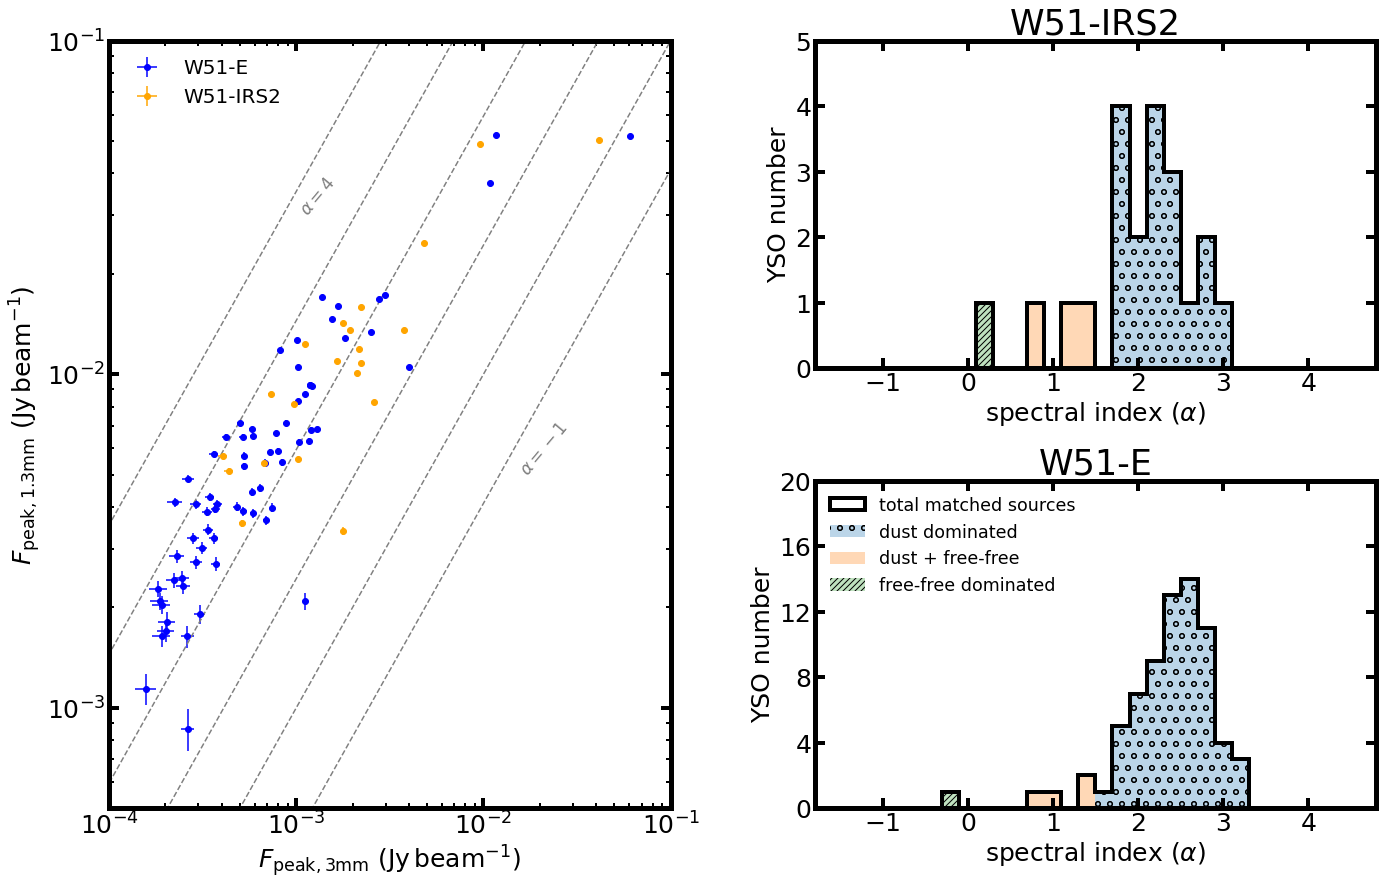

In [6]:
import matplotlib as mpl
import astropy.constants as c
from scipy.interpolate import CubicSpline

def get_bb_intensity(freq, surf_den,T_thin):
    
    kappa_ = kappa(freq)
    
    I_nu =  2 * c.h * freq**3 / (c.c**2) * (np.e**(c.h*freq/(c.k_B*T_thin)) - 1)**(-1) * (1 - np.e**((-kappa_ * surf_den).to(u.dimensionless_unscaled))) /u.sr
    
    return I_nu.to(u.Jy/u.sr)
def kappa(nu, nu0=271.1*u.GHz, kappa0=0.0114*u.cm**2*u.g**-1, beta=1.75):
    """
    Compute the opacity $\kappa$ given a reference frequency (or wavelength)
    and a power law governing the opacity as a fuction of frequency:
    $$ \kappa = \kappa_0 \left(\\frac{\\nu}{\\nu_0}\\right)^{\\beta} $$
    The default kappa=0.0114 at 271.1 GHz comes from extrapolating the
    Ossenkopf & Henning 1994 opacities for the thin-ice-mantle, 10^6 year model
    anchored at 1.0 mm with an assumed beta of 1.75.
    Parameters
    ----------
    nu: astropy.Quantity [u.spectral() equivalent]
        The frequency at which to evaluate kappa
    nu0: astropy.Quantity [u.spectral() equivalent]
        The reference frequency at which $\kappa$ is defined
    kappa0: astropy.Quantity [cm^2/g]
        The dust opacity per gram of H2 along the line of sight.  Because of
        the H2 conversion, this factor implicitly includes a dust to gas ratio
        (usually assumed 100)
    beta: float
        The power-law index governing kappa as a function of nu
    """
    return (kappa0*(nu.to(u.GHz,u.spectral())/nu0.to(u.GHz,u.spectral()))**(beta)).to(u.cm**2/u.g)
plt.rcParams['axes.labelsize']=25
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25
plt.rcParams['axes.titlesize']=25
mpl.rcParams['axes.linewidth'] = 5
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 4
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 4
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 2
params = {"xtick.top": True, "ytick.right": True, "xtick.direction": "in", "ytick.direction": "in"}
plt.rcParams.update(params)
w51ecat = Table.read(Path.w51e_dendro_matched_catalog)
w51e_matched = np.where(w51ecat['is_matched'])[0]
w51ncat = Table.read(Path.w51n_dendro_matched_catalog)
w51n_matched = np.where(w51ncat['is_matched'])[0]
w51e_unmatched_b3 = np.where(w51ecat['b3_xsky']<0)[0]
w51e_unmatched_b6 = np.where(w51ecat['b6_xsky']<0)[0]
w51n_unmatched_b3 = np.where(w51ncat['b3_xsky']<0)[0]
w51n_unmatched_b6 = np.where(w51ncat['b6_xsky']<0)[0]

hdrNB6 = fits.getheader(Path.w51e_b6_conv)  
hdrNB3 = fits.getheader(Path.w51e_b3_tt0)  


my_beamNB3 = Beam.from_fits_header(hdrNB3)
my_beamNB6 = Beam.from_fits_header(hdrNB6)
    

alpha_w51e = w51ecat['alpha']
alpha_w51n = w51ncat['alpha']
alpha_w51e_err = np.abs(w51ecat['alphaerr'])
alpha_w51n_err = np.abs(w51ncat['alphaerr'])

b3peak_w51e = w51ecat['flux_peak_b3'] 
b6peak_w51e = w51ecat['flux_peak_b6'] 

b3peak_w51n = w51ncat['flux_peak_b3'] 
b6peak_w51n = w51ncat['flux_peak_b6'] 

b3noise_w51e = 2.065537678896079e-05 
b6noise_w51e = 0.00012361802520203196
b3noise_w51n = 2.220660593897177e-05
b6noise_w51n = 8.95845803518789e-05

groupa_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e>1.5))[0]

groupb_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e<1.5)&(alpha_w51e>0.5))
groupc_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e<0.5))[0]

grouparr = np.zeros(len(alpha_w51e))
grouparr[groupa_ind_w51e]=0
grouparr[groupb_ind_w51e]=1
grouparr[groupc_ind_w51e]=2

w51ecat['group']=grouparr
for i in range(100):
    print(i, w51ecat['alpha'][i])
for i in range(20):
    print(i, w51ncat['alpha'][i])
groupa_ind_w51n = np.where((w51ncat['is_matched'])&(alpha_w51n>1.5))[0]

groupb_ind_w51n = np.where((w51ncat['is_matched'])&(alpha_w51n<1.5)&(alpha_w51n>0.5))
groupc_ind_w51n = np.where((w51ncat['is_matched'])&(alpha_w51n<0.5))[0]

grouparr = np.zeros(len(alpha_w51n))
grouparr[groupa_ind_w51n]=0
grouparr[groupb_ind_w51n]=1
grouparr[groupc_ind_w51n]=2

w51ncat['group']=grouparr


#alpha_w51n_err = np.sqrt((b3noise/b3flux)**2+(b6noise/b6flux)**2)/np.log(freqb3/freqb6)
#alpha_w51e_err =np.sqrt((b3noise/b3flux)**2+(b6noise/b6flux)**2)/np.log(freqb3/freqb6)
hdrNB6 = fits.getheader(Path.w51e_b6_cont)  
hdrNB3 = fits.getheader(Path.w51e_b3_tt0)  
b3freq = cen_freq(hdrNB3['CRVAL3'],hdrNB3['CDELT4'])
b6freq = cen_freq(hdrNB6['CRVAL4'],hdrNB6['CDELT4'])

fig = plt.figure(figsize=(20,13))
ax1 = fig.add_axes([0.1,0.08,0.39,0.82])
ax2 = fig.add_axes([0.59,0.08,0.39,0.35])
ax3 = fig.add_axes([0.59,0.55,0.39,0.35])

ax1.errorbar( b3peak_w51e[w51e_matched],b6peak_w51e[w51e_matched], xerr=b3noise_w51e, yerr=b6noise_w51e,fmt='o',c='b', label='W51-E')
ax1.errorbar( b3peak_w51n[w51n_matched],b6peak_w51n[w51n_matched], xerr=b3noise_w51n, yerr=b6noise_w51n,fmt='o',c='orange', label='W51-IRS2')
spectral_indices=[-1,0,1,2,3,4]
for si in spectral_indices:
    ax1.plot([1e-5,1e-1],10**(np.log10([1e-5,1e-1]) - np.log10(b3freq/b6freq) * si), c='grey',ls='dashed') 
ax1.text(1e-3,3e-2,r'$\alpha=4$',rotation=50,fontsize=17,c='gray')
ax1.text(1.5e-2,5e-3,r'$\alpha=-1$',rotation=50,fontsize=17,c='gray')    
ax1.set_ylabel(r'$F_{\rm peak, 1.3 mm}$ (${\rm Jy\,beam^{-1}}$)')
ax1.set_xlabel(r'$F_{\rm peak, 3 mm}$ (${\rm Jy\,beam^{-1}}$)')
ax1.set_xlim(1e-4,1e-1)
ax1.set_ylim(5e-4,1e-1)

ax1.set_xscale('log')
ax1.set_yscale('log')

avg_gas_mass = 2.8 * c.u # from https://dust-emissivity.readthedocs.io/en/latest/api/dust_emissivity.blackbody.modified_blackbody.html
H_2_den_min = 1e+21 / u.cm**2
H_2_den_max = 1e+27 / u.cm**2
den_min = ((H_2_den_min  * avg_gas_mass).to(u.kg/u.m**2)).value
den_max = ((H_2_den_max * avg_gas_mass).to(u.kg/u.m**2)).value
surf_den = np.geomspace(den_min, den_max, 1000) * u.kg / u.m**2
freq93 = 92.98 * u.GHz
freq225 = 226.69 * u.GHz
b3flux_20 = get_bb_intensity(freq93, surf_den, 20*u.K) * my_beamNB3.sr 
b6flux_20 = get_bb_intensity(freq225, surf_den, 20*u.K)* my_beamNB6.sr

b3flux_50 = get_bb_intensity(freq93, surf_den, 50*u.K)* my_beamNB3.sr
b6flux_50 = get_bb_intensity(freq225, surf_den, 50*u.K)* my_beamNB6.sr

b3flux_100 = get_bb_intensity(freq93, surf_den, 100*u.K)* my_beamNB3.sr
b6flux_100 = get_bb_intensity(freq225, surf_den, 100*u.K)* my_beamNB6.sr

b3flux_1 = get_bb_intensity(freq93, surf_den, 1*u.K) * my_beamNB3.sr
b6flux_1 = get_bb_intensity(freq225, surf_den, 1*u.K)* my_beamNB6.sr
b3flux_500 = get_bb_intensity(freq93, surf_den, 500*u.K)* my_beamNB3.sr
b6flux_500 = get_bb_intensity(freq225, surf_den, 500*u.K)* my_beamNB6.sr

b3flux_lowlimit_curve_over1 = get_bb_intensity(freq93, surf_den[-1], np.arange(2,500,1)*u.K)* my_beamNB3.sr
b6flux_lowlimit_curve_over1 = get_bb_intensity(freq225, surf_den[-1], np.arange(2,500,1)*u.K)* my_beamNB3.sr
b3flux_lowlimit_curve = np.concatenate((b3flux_1.value, b3flux_lowlimit_curve_over1.value))
b6flux_lowlimit_curve = np.concatenate((b6flux_1.value, b6flux_lowlimit_curve_over1.value))
interp = CubicSpline(b3flux_500.value, b6flux_500.value)
#ax1.fill_between(b3flux_lowlimit_curve, b6flux_lowlimit_curve, interp(b3flux_lowlimit_curve), color='chartreuse', alpha=0.3,label='modified blackbody T=1-500K')

colors=sns.color_palette("tab10")
print(len(groupa_ind_w51e),len(groupb_ind_w51e),len(groupc_ind_w51e))
print(len(groupa_ind_w51n),len(groupb_ind_w51n),len(groupc_ind_w51n))

#ax1.plot(b3flux_20.to(u.Jy), b6flux_20.to(u.Jy), c='r', ls='dotted',lw=3, label='T=20K')
#ax1.plot(b3flux_50.to(u.Jy), b6flux_50.to(u.Jy), c='magenta', ls='dotted',lw=3,label='T=50K')
#ax1.plot(b3flux_100.to(u.Jy), b6flux_100.to(u.Jy), c='cyan', ls='dotted',lw=3,label='T=100K')
ax1.legend(fontsize=20,frameon=False,loc='upper left')

bins = np.linspace(-1.5,4.5,31)
ax2.hist(alpha_w51e[w51e_matched], bins=bins, facecolor='none',edgecolor='k', histtype='step',label='total matched sources',lw=4)
ax2.hist(alpha_w51e[groupa_ind_w51e], bins=bins, alpha=0.3, color=colors[0], label='dust dominated',hatch='o')
ax2.hist(alpha_w51e[groupb_ind_w51e], bins=bins, alpha=0.3, color=colors[1], label='dust + free-free')
ax2.hist(alpha_w51e[groupc_ind_w51e], bins=bins, alpha=0.3, color=colors[2], label='free-free dominated',hatch='////')
ax2.set_title('W51-E', fontsize=35)
ax2.set_ylim(0,20)
ax3.hist(alpha_w51n[w51n_matched], bins=bins, facecolor='none',edgecolor='k', histtype='step',label='total matched sources',lw=4)
ax3.hist(alpha_w51n[groupa_ind_w51n], bins=bins, alpha=0.3, color=colors[0], label='dust dominated',hatch='o')
ax3.hist(alpha_w51n[groupb_ind_w51n], bins=bins, alpha=0.3, color=colors[1], label='dust + free-free')
ax3.hist(alpha_w51n[groupc_ind_w51n], bins=bins, alpha=0.3, color=colors[2], label='free-free dominated',hatch='////')
ax2.set_xlabel(r'spectral index $(\alpha)$')
ax2.set_ylabel('YSO number')
ax2.legend(fontsize=17.5, frameon=False,loc='upper left')
ax2.set_xticks([-1,0,1,2,3,4])
ax2.set_yticks([0,4,8,12,16,20])
ax3.set_title('W51-IRS2',fontsize=35)

ax3.set_xlabel(r'spectral index $(\alpha)$')
ax3.set_ylabel('YSO number')
ax3.set_xticks([-1,0,1,2,3,4])
ax3.set_yticks([0,1,2,3,4,5])

plt.savefig('spectral_indices3.png')

In [7]:
w51ecat.write(w51e_matched_catalog, overwrite=True,format='fits')
w51ncat.write(w51n_matched_catalog, overwrite=True,format='fits')


HIIind_w51e = np.where((alpha_w51e<0.5)&(w51ecat['is_matched']))[0]

HIIind_w51n = np.where((alpha_w51n<0.5)&(w51ncat['is_matched']))[0]

print(HIIind_w51e,HIIind_w51n )

NameError: name 'w51e_matched_catalog' is not defined

In [ ]:
import matplotlib as mpl
import astropy.constants as c
from scipy.interpolate import CubicSpline

def get_bb_intensity(freq, surf_den,T_thin):
    
    kappa_ = kappa(freq)
    
    I_nu =  2 * c.h * freq**3 / (c.c**2) * (np.e**(c.h*freq/(c.k_B*T_thin)) - 1)**(-1) * (1 - np.e**((-kappa_ * surf_den).to(u.dimensionless_unscaled))) /u.sr
    
    return I_nu.to(u.Jy/u.sr)
def kappa(nu, nu0=271.1*u.GHz, kappa0=0.0114*u.cm**2*u.g**-1, beta=1.75):
    """
    Compute the opacity $\kappa$ given a reference frequency (or wavelength)
    and a power law governing the opacity as a fuction of frequency:
    $$ \kappa = \kappa_0 \left(\\frac{\\nu}{\\nu_0}\\right)^{\\beta} $$
    The default kappa=0.0114 at 271.1 GHz comes from extrapolating the
    Ossenkopf & Henning 1994 opacities for the thin-ice-mantle, 10^6 year model
    anchored at 1.0 mm with an assumed beta of 1.75.
    Parameters
    ----------
    nu: astropy.Quantity [u.spectral() equivalent]
        The frequency at which to evaluate kappa
    nu0: astropy.Quantity [u.spectral() equivalent]
        The reference frequency at which $\kappa$ is defined
    kappa0: astropy.Quantity [cm^2/g]
        The dust opacity per gram of H2 along the line of sight.  Because of
        the H2 conversion, this factor implicitly includes a dust to gas ratio
        (usually assumed 100)
    beta: float
        The power-law index governing kappa as a function of nu
    """
    return (kappa0*(nu.to(u.GHz,u.spectral())/nu0.to(u.GHz,u.spectral()))**(beta)).to(u.cm**2/u.g)
plt.rcParams['axes.labelsize']=25
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25
plt.rcParams['axes.titlesize']=25
mpl.rcParams['axes.linewidth'] = 5
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 4
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 4
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 2
params = {"xtick.top": True, "ytick.right": True, "xtick.direction": "in", "ytick.direction": "in"}
plt.rcParams.update(params)
w51ecat = Table.read(w51e_matched_catalog)
w51e_matched = np.where(w51ecat['is_matched'])[0]
w51ncat = Table.read(w51n_matched_catalog)
w51n_matched = np.where(w51ncat['is_matched'])[0]
w51e_unmatched_b3 = np.where(w51ecat['b3_xsky']<0)[0]
w51e_unmatched_b6 = np.where(w51ecat['b6_xsky']<0)[0]
w51n_unmatched_b3 = np.where(w51ncat['b3_xsky']<0)[0]
w51n_unmatched_b6 = np.where(w51ncat['b6_xsky']<0)[0]

hdrNB6 = fits.getheader(Path.w51e_b6_conv)  
hdrNB3 = fits.getheader(Path.w51e_b3_tt0)  


my_beamNB3 = Beam.from_fits_header(hdrNB3)
my_beamNB6 = Beam.from_fits_header(hdrNB6)
    

alpha_w51e = w51ecat['alpha']
alpha_w51n = w51ncat['alpha']
alpha_w51e_err = np.abs(w51ecat['alphaerr'])
alpha_w51n_err = np.abs(w51ncat['alphaerr'])

b3peak_w51e = w51ecat['flux_peak_b3'] 
b6peak_w51e = w51ecat['flux_peak_b6'] 

b3peak_w51n = w51ncat['flux_peak_b3'] 
b6peak_w51n = w51ncat['flux_peak_b6'] 

b3noise_w51e = 2.065537678896079e-05 
b6noise_w51e = 0.00012361802520203196
b3noise_w51n = 2.220660593897177e-05
b6noise_w51n = 8.95845803518789e-05

groupa_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e-alpha_w51e_err>2))[0]
groupb1_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e>2)&(alpha_w51e-alpha_w51e_err<2))[0]
groupb2_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e<2)&(alpha_w51e+alpha_w51e_err>2))[0]
groupb_ind_w51e = np.append(groupb1_ind_w51e,groupb2_ind_w51e)
groupc_ind_w51e = np.where((w51ecat['is_matched'])&(alpha_w51e+alpha_w51e_err<2))[0]

grouparr = np.zeros(len(alpha_w51e))
grouparr[groupa_ind_w51e]=0
grouparr[groupb_ind_w51e]=1
grouparr[groupc_ind_w51e]=2

w51ecat['group']=grouparr

print(alpha_w51e_err)
groupa_ind_w51n = np.where((w51ncat['is_matched'])&(alpha_w51n-alpha_w51n_err>2))[0]
groupb1_ind_w51n = np.where((w51ncat['is_matched'])&(alpha_w51n>2)&(alpha_w51n-alpha_w51n_err<2))[0]
groupb2_ind_w51n = np.where((w51ncat['is_matched'])&(alpha_w51n<2)&(alpha_w51n+alpha_w51n_err>2))[0]
groupb_ind_w51n = np.append(groupb1_ind_w51n,groupb2_ind_w51n)
groupc_ind_w51n = np.where((w51ncat['is_matched'])&(alpha_w51n+alpha_w51n_err<2))[0]

grouparr = np.zeros(len(alpha_w51n))
grouparr[groupa_ind_w51n]=0
grouparr[groupb_ind_w51n]=1
grouparr[groupc_ind_w51n]=2

w51ncat['group']=grouparr


#alpha_w51n_err = np.sqrt((b3noise/b3flux)**2+(b6noise/b6flux)**2)/np.log(freqb3/freqb6)
#alpha_w51e_err =np.sqrt((b3noise/b3flux)**2+(b6noise/b6flux)**2)/np.log(freqb3/freqb6)
hdrNB6 = fits.getheader(w51e_b6_calibrated_pbcor)  
hdrNB3 = fits.getheader(w51e_b3_tt0)  
b3freq = cen_freq(hdrNB3['CRVAL3'],hdrNB3['CDELT4'])
b6freq = cen_freq(hdrNB6['CRVAL4'],hdrNB6['CDELT4'])

fig = plt.figure(figsize=(27,9))
ax1 = fig.add_axes([0.06,0.1,0.28,0.83])
ax2 = fig.add_axes([0.39,0.1,0.28,0.83])
ax3 = fig.add_axes([0.72,0.1,0.28,0.83])

ax1.errorbar( b3peak_w51e[w51e_matched],b6peak_w51e[w51e_matched], xerr=b3noise_w51e, yerr=b6noise_w51e,fmt='o',c='b', label='W51-E')
ax1.errorbar( b3peak_w51n[w51n_matched],b6peak_w51n[w51n_matched], xerr=b3noise_w51n, yerr=b6noise_w51n,fmt='o',c='orange', label='W51-IRS2')
spectral_indices=[-1,0,1,2,3,4]
for si in spectral_indices:
    ax1.plot([1e-5,1e-1],10**(np.log10([1e-5,1e-1]) - np.log10(b3freq/b6freq) * si), c='grey',ls='dashed') 
ax1.text(1e-3,3e-2,r'$\alpha=4$',rotation=50,fontsize=17,c='gray')
ax1.text(1.5e-2,5e-3,r'$\alpha=-1$',rotation=50,fontsize=17,c='gray')    
ax1.set_ylabel(r'$F_{\rm peak, 1.3 mm}$ (Jy/beam)')
ax1.set_xlabel(r'$F_{\rm peak, 3 mm}$ (Jy/beam)')
ax1.set_xlim(1e-4,1e-1)
ax1.set_ylim(5e-4,1e-1)

ax1.set_xscale('log')
ax1.set_yscale('log')

avg_gas_mass = 2.8 * c.u # from https://dust-emissivity.readthedocs.io/en/latest/api/dust_emissivity.blackbody.modified_blackbody.html
H_2_den_min = 1e+21 / u.cm**2
H_2_den_max = 1e+27 / u.cm**2
den_min = ((H_2_den_min  * avg_gas_mass).to(u.kg/u.m**2)).value
den_max = ((H_2_den_max * avg_gas_mass).to(u.kg/u.m**2)).value
surf_den = np.geomspace(den_min, den_max, 1000) * u.kg / u.m**2
freq93 = 92.98 * u.GHz
freq225 = 226.69 * u.GHz
b3flux_20 = get_bb_intensity(freq93, surf_den, 20*u.K) * my_beamNB3.sr 
b6flux_20 = get_bb_intensity(freq225, surf_den, 20*u.K)* my_beamNB6.sr

b3flux_50 = get_bb_intensity(freq93, surf_den, 50*u.K)* my_beamNB3.sr
b6flux_50 = get_bb_intensity(freq225, surf_den, 50*u.K)* my_beamNB6.sr

b3flux_100 = get_bb_intensity(freq93, surf_den, 100*u.K)* my_beamNB3.sr
b6flux_100 = get_bb_intensity(freq225, surf_den, 100*u.K)* my_beamNB6.sr

b3flux_1 = get_bb_intensity(freq93, surf_den, 1*u.K) * my_beamNB3.sr
b6flux_1 = get_bb_intensity(freq225, surf_den, 1*u.K)* my_beamNB6.sr
b3flux_500 = get_bb_intensity(freq93, surf_den, 500*u.K)* my_beamNB3.sr
b6flux_500 = get_bb_intensity(freq225, surf_den, 500*u.K)* my_beamNB6.sr

b3flux_lowlimit_curve_over1 = get_bb_intensity(freq93, surf_den[-1], np.arange(2,500,1)*u.K)* my_beamNB3.sr
b6flux_lowlimit_curve_over1 = get_bb_intensity(freq225, surf_den[-1], np.arange(2,500,1)*u.K)* my_beamNB3.sr
b3flux_lowlimit_curve = np.concatenate((b3flux_1.value, b3flux_lowlimit_curve_over1.value))
b6flux_lowlimit_curve = np.concatenate((b6flux_1.value, b6flux_lowlimit_curve_over1.value))
interp = CubicSpline(b3flux_500.value, b6flux_500.value)
ax1.fill_between(b3flux_lowlimit_curve, b6flux_lowlimit_curve, interp(b3flux_lowlimit_curve), color='chartreuse', alpha=0.3,label='modified blackbody T=1-500K')

colors=sns.color_palette("tab10")
print(len(groupa_ind_w51e),len(groupb_ind_w51e),len(groupc_ind_w51e))
print(len(groupa_ind_w51n),len(groupb_ind_w51n),len(groupc_ind_w51n))

#ax1.plot(b3flux_20.to(u.Jy), b6flux_20.to(u.Jy), c='r', ls='dotted',lw=3, label='T=20K')
#ax1.plot(b3flux_50.to(u.Jy), b6flux_50.to(u.Jy), c='magenta', ls='dotted',lw=3,label='T=50K')
#ax1.plot(b3flux_100.to(u.Jy), b6flux_100.to(u.Jy), c='cyan', ls='dotted',lw=3,label='T=100K')
ax1.legend(fontsize=20,frameon=False,loc='upper left')

bins = np.linspace(-1.5,4.5,31)
ax2.hist(alpha_w51e[w51e_matched], bins=bins, facecolor='none',edgecolor='k', histtype='step',label='total matched sources',lw=4)
ax2.hist(alpha_w51e[groupa_ind_w51e], bins=bins, alpha=0.3, color=colors[0], label=r'group A ($\alpha-\sigma(\alpha)>2$)',hatch='o')
ax2.hist(alpha_w51e[groupb_ind_w51e], bins=bins, alpha=0.3, color=colors[1], label=r'group B (($\alpha>2$, $\alpha-\sigma(\alpha)<2$)'+'\n'+r'or ($\alpha<2$, $\alpha+\sigma(\alpha)>2$)')
ax2.hist(alpha_w51e[groupc_ind_w51e], bins=bins, alpha=0.3, color=colors[2], label=r'group C ($\alpha+\sigma(\alpha)<2$)',hatch='////')
ax2.set_title('W51-E', fontsize=35)

ax3.hist(alpha_w51n[w51n_matched], bins=bins, facecolor='none',edgecolor='k', histtype='step',label='total matched sources',lw=4)
ax3.hist(alpha_w51n[groupa_ind_w51n], bins=bins, alpha=0.3, color=colors[0], label='group A',hatch='o')
ax3.hist(alpha_w51n[groupb_ind_w51n], bins=bins, alpha=0.3, color=colors[1], label='group B')
ax3.hist(alpha_w51n[groupc_ind_w51n], bins=bins, alpha=0.3, color=colors[2], label='group C',hatch='////')
ax2.set_xlabel('spectral indices')
ax2.set_ylabel('YSO number')
ax2.legend(fontsize=17.5, frameon=False,loc='upper left')
ax2.set_xticks([-1,0,1,2,3,4])
ax2.set_yticks([0,2,4,6,8,10,12,14,16])
ax3.set_title('W51-IRS2',fontsize=35)

ax3.set_xlabel('spectral indices')
ax3.set_ylabel('YSO number')
ax3.set_xticks([-1,0,1,2,3,4])
ax3.set_yticks([0,1,2,3,4,5])

plt.savefig('spectral_indices.png')



In [ ]:
w51ecat.write(w51e_matched_catalog, overwrite=True,format='fits')
w51ncat.write(w51n_matched_catalog, overwrite=True,format='fits')


HIIind_w51e = np.where((alpha_w51e<0.5)&(w51ecat['is_matched']))[0]

HIIind_w51n = np.where((alpha_w51n<0.5)&(w51ncat['is_matched']))[0]

print(HIIind_w51e,HIIind_w51n )